# Deep Q Network로의 여행.
# Part III. Double & Dueling

![좋은 그림](https://d3i71xaburhd42.cloudfront.net/e6a1640c03c50a55ef3e00a0592dbb0851fe33bb/3-Figure1-1.png)

[읽어보면 좋은 것 0](https://www.katnoria.com/static/e59c56013a5d82a0ae94d9413076dfc0/1e043/dqn_algo.png)<br>
[읽어보면 좋은 것 1](https://arxiv.org/pdf/1312.5602.pdf)<br>
[읽어보면 좋은 것 2](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf)



# 라이브러리 설치 / 불러오기

In [1]:
%%time
## 약 25초 ~30초 소요
!pip install pyvirtualdisplay 
!apt-get install -y xvfb python-opengl ffmpeg
!pip install gym
!pip install box2d-py
#!pip install pyglet==1.3.2
!pip install pyglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
CPU times: user 53.1 ms, sys: 30.5 ms, total: 83.6 ms
Wall time: 11.9 s


In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()

비디오 녹화용 함수

In [4]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[-1]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# LunarLander-v2

In [5]:
from time import sleep

In [6]:
env = wrap_env(gym.make("LunarLander-v2"))
print('observation space:', env.observation_space)
print('action space:', env.action_space)

# for i in range(10) :
state = env.reset()
for t in range(1000):
    action = env.action_space.sample() # your agent here (this takes random actions)
    env.render()
    observation, reward, done, info = env.step(action)
    if done: 
        break
            
print('steps: ', t)
env.close()
show_video()

observation space: Box(-inf, inf, (8,), float32)
action space: Discrete(4)
steps:  84


# Deep Neural Network for Q-function

**Q-function기능을 할 뉴럴넷을 구성할 것이다.**
1. input은 state다. (노드 수는?)
2. output은 그 state에서 취할 수 있는 action에 대한 Q값이다. (노드 수는?)

[좋은그림](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F9911AF455B9A0A9706)<br>
[좋은그림1](https://i.ytimg.com/vi/2-zGCx4iv_k/hqdefault.jpg)
![좋은그림1](https://theaisummer.com/assets/img/posts/Taking_Deep_Q_Networks_a_step_further/DDQN.jpg)


### State와 Action 정의
* The state. Attributes:
  * s[0] is the horizontal coordinate
  * s[1] is the vertical coordinate
  * s[2] is the horizontal speed
  * s[3] is the vertical speed
  * s[4] is the angle
  * s[5] is the angular speed
  * s[6] 1 if first leg has contact, else 0
  * s[7] 1 if second leg has contact, else 0

* The Action.
  * Nop, fire left engine, main engine, right engine

In [8]:
print("state 수는? : ", env.observation_space.shape)
print("action 수는? : ", env.action_space.n)

state 수는? :  (8,)
action 수는? :  4


In [9]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Dense, Add, Subtract, Average, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

In [10]:
### 이것은 일단 그냥 사용해보자!
### huber 로스!
from tensorflow.keras.losses import Huber
def mean_huber_loss(y_true, y_pred, clip_delta=1.0):
    return tf.keras.backend.mean(Huber(clip_delta)(y_true, y_pred))

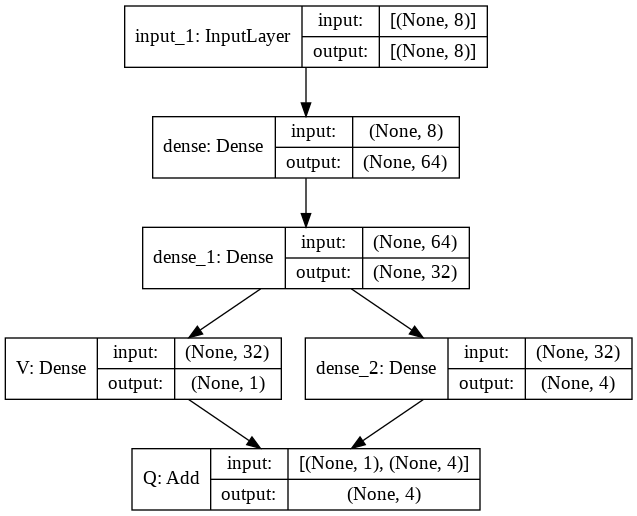

In [11]:
keras.backend.clear_session()
######################
### Your Code Here ###
######################

state_layer = Input(shape=(8,))  # env.observation_space.shape[0]
hidden = Dense(64, activation='relu')(state_layer)
hidden = Dense(32, activation='relu')(hidden)
v_layer = Dense(1, name='V')(hidden)
a_layer = Dense(4)(hidden)       # env.action_space.n
# a_layer = Lambda(lambda a: a[:, :] - tf.keras.backend.mean(a[:,:],axis=1, keepdims=True ),name='Advantage')(a_layer)

q_layer = Add(name="Q")([v_layer, a_layer]) #Broadcast 해준다

Q_network = Model(state_layer, q_layer)

Q_network.compile(loss = mean_huber_loss,
              optimizer = Adam(0.0001))

# Q_network.summary()

plot_model(Q_network, show_shapes=True)

### 위 코드를 보고 target_Q_network를 구성하시오.

* 똑같으면 된다.
* 단, 모델 이름은 target_Q_network

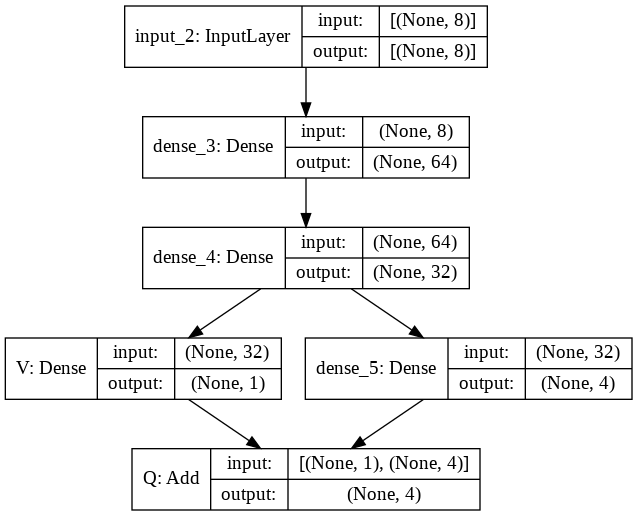

In [12]:
# keras.backend.clear_session()
######################
### Your Code Here ###
######################

state_layer = Input(shape=(8,))  # env.observation_space.shape[0]
hidden = Dense(64, activation='relu')(state_layer)
hidden = Dense(32, activation='relu')(hidden)
v_layer = Dense(1, name='V')(hidden)
a_layer = Dense(4)(hidden)       # env.action_space.n
# a_layer = Lambda(lambda a: a[:, :] - tf.keras.backend.mean(a[:,:],axis=1, keepdims=True ),name='Advantage')(a_layer)

q_layer = Add(name="Q")([v_layer, a_layer]) #Broadcast 해준다

target_Q_network = Model(state_layer, q_layer)

target_Q_network.compile(loss = mean_huber_loss,
              optimizer = Adam(0.0001))

# Q_network.summary()

plot_model(target_Q_network, show_shapes=True)

In [13]:
## Target Q 네트워크의 가중치는 같아야 한다.
target_Q_network.set_weights(Q_network.get_weights())

# Memory 구현 & Memory에 어느정도 Experience를 담아두기!

1. (s0, a0, r1, s1, done)을 담아두면 된다. 튜플!
2. deque를 이용하여 최근 십만개의 Experience만 담아둘수 있도록 한다.
3. Experience 를 replay하며 배울 때는..
    * sample_size = bach_size = 128 개씩 경험을 랜덤추출하여 .fit()할 것이다!
    * 따라서 experience(s0, a0, r1, s1, done)은 충분히 미리 담아두자.
    * 랜덤액션으로 담아두어도 좋다.

In [14]:
from collections import deque
memory = deque(maxlen = 20000)  # 리스트 처럼 사용이 가능하다.

In [15]:
alpha = 0.1
gamma = 0.99
n_episod = 100
epsilon = 0.1
pre_play = 100 # 실제 담기는건 10개가 아닐 것!

for i in range(pre_play) :
    print(i, " 번째 에피소드,")
    s0 = env.reset()
    s0 = s0.reshape([1, -1]) # 2차원 어레이로 바꿔주기
    done = False

    while True :

        a0 = env.action_space.sample() # 랜덤 액션!
        # 환경과 상호작용!
        s1, r1, done, _ = env.step(a0)
        s1 = s1.reshape([1,-1]) # 2차원 어레이로 바꿔주기

        if done == False :
            memory.append( (s0, a0, r1, s1, done) )
            s0 = s1
        else :
            s1 = np.zeros(s0.shape)  # 끝나면 s1가 0이 됨!
            memory.append( (s0, a0, r1, s1, done) )
            env.close()
            break
    print("저장된 experience : {}".format(len(memory)))

0  번째 에피소드,
저장된 experience : 105
1  번째 에피소드,
저장된 experience : 195
2  번째 에피소드,
저장된 experience : 262
3  번째 에피소드,
저장된 experience : 326
4  번째 에피소드,
저장된 experience : 407
5  번째 에피소드,
저장된 experience : 473
6  번째 에피소드,
저장된 experience : 588
7  번째 에피소드,
저장된 experience : 667
8  번째 에피소드,
저장된 experience : 745
9  번째 에피소드,
저장된 experience : 840
10  번째 에피소드,
저장된 experience : 959
11  번째 에피소드,
저장된 experience : 1054
12  번째 에피소드,
저장된 experience : 1134
13  번째 에피소드,
저장된 experience : 1254
14  번째 에피소드,
저장된 experience : 1350
15  번째 에피소드,
저장된 experience : 1422
16  번째 에피소드,
저장된 experience : 1484
17  번째 에피소드,
저장된 experience : 1579
18  번째 에피소드,
저장된 experience : 1647
19  번째 에피소드,
저장된 experience : 1764
20  번째 에피소드,
저장된 experience : 1839
21  번째 에피소드,
저장된 experience : 1921
22  번째 에피소드,
저장된 experience : 2042
23  번째 에피소드,
저장된 experience : 2142
24  번째 에피소드,
저장된 experience : 2242
25  번째 에피소드,
저장된 experience : 2356
26  번째 에피소드,
저장된 experience : 2478
27  번째 에피소드,
저장된 experience : 2607
28  번째 에피소드,
저장된 experience : 2689
29  번째

In [16]:
print(f'리스트 메모리 길이 : {len(memory)}')
print(f'* 메모리 내용 1개 보기')
print(f'  - 메모리 첫번째(리스크 첫번째) : s0(8), a0(0~4중 max), r1(int), s1(8), done(boolean) 구성')
print(f'  - s0 : {memory[0][0]}')
print(f'  - a0 : {memory[0][1]}')
print(f'  - r1 : {memory[0][2]}')
print(f'  - s1 : {memory[0][3]}')
print(f'  - done : {memory[0][4]}')

리스트 메모리 길이 : 9413
* 메모리 내용 1개 보기
  - 메모리 첫번째(리스크 첫번째) : s0(8), a0(0~4중 max), r1(int), s1(8), done(boolean) 구성
  - s0 : [[ 9.2830660e-04  1.4192061e+00  9.4015971e-02  3.6826366e-01
  -1.0689266e-03 -2.1296009e-02  0.0000000e+00  0.0000000e+00]]
  - a0 : 3
  - r1 : 1.1444340630212377
  - s1 : [[ 0.0019289   1.426915    0.10296073  0.34261304 -0.00394051 -0.05743638
   0.          0.        ]]
  - done : False


# Memory로 부터 배치 사이즈 만큼 데이터를 떼어 오는 함수 제작

* .fit(s0, target_Q) 임을 고려하자
* 심지어 이제 진짜 target_Q_network 를 이용하여 만들어야 하는것이 맞다.


In [17]:
import random
def create_batch(target_model, memory, gamma, batch_size = 128):
    sample = np.array(random.sample(memory, batch_size))

    s0 = sample[:, 0]
    a0 = sample[:, 1].astype(np.int8)
    r1 = sample[:, 2]
    s1 = sample[:, 3]
    d = sample[:, 4]

    s0_batch = np.vstack(s0)
    s1_batch = np.vstack(s1)

    target_Q_batch = target_model.predict(s0_batch)
    Q_s1 = target_model.predict(s1_batch)
    ###### Q-table에서 업데이트는 ? #############################################
    ## Q[s0, a0] = Q[s0, a0] + alpha * (r1 + gamma*np.max(Q[s1,:]) - Q[s0, a0]) #
    #############################################################################

    target_Q_batch[np.arange(batch_size),a0] = r1 + gamma*np.max(Q_s1, axis=1)*(1-d)

    return s0_batch, target_Q_batch

# Memory로 부터 학습 하는 Q-Network!

episode 1 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 2 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 3 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 4 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 5 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 6 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 7 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 8 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 9 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 10 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 10  ============
최종누적보상 : -151.9849685080421
2 [[0.45367494 0.18222944 0.5739639  0.08472369]]


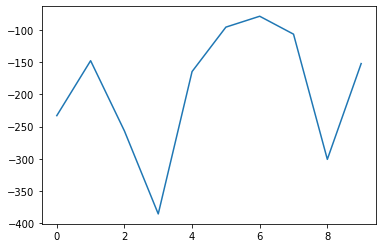

episode 11 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 12 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 13 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 14 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 15 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 16 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 17 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 18 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 19 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 20 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 20  ============
최종누적보상 : -123.4865538601184
1 [[0.3986513  0.40934736 0.17102136 0.01404282]]


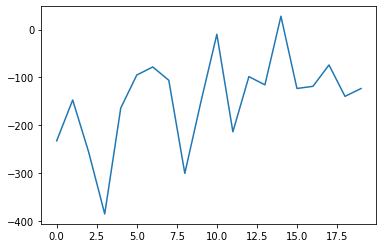

episode 21 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 22 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 23 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 24 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 25 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 26 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 27 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 28 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 29 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 30 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 30  ============
최종누적보상 : -105.36730864077106
0 [[0.50201595 0.2405989  0.3745187  0.21378215]]


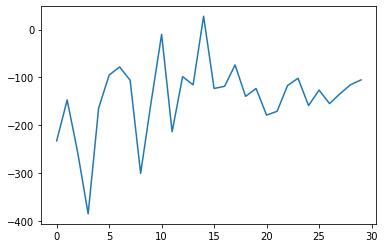

episode 31 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 32 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 33 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 34 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 35 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 36 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 37 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 38 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 39 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 40 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 40  ============
최종누적보상 : -121.61731056590772
2 [[ 0.21165468 -0.01788783  0.48378944 -0.07441869]]


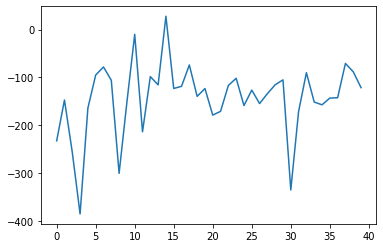

episode 41 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 42 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 43 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 44 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 45 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 46 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 47 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 48 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 49 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 50 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 50  ============
최종누적보상 : -68.86902800293142
1 [[ 0.30972588  0.44503447 -0.03256899 -0.23247555]]


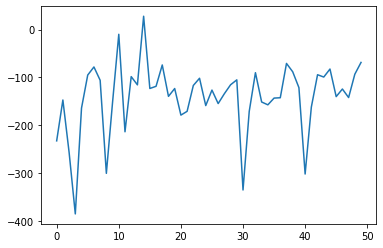

episode 51 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 52 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 53 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: ignored

In [18]:
env.close()

alpha = 0.1
gamma = 0.99
n_episod = 2000

epsilon = 0.5

sample_size = batch_size = 128
cum_rewards = []
tq_update = 4 ## target_Q는 언제 업데이트 할래?

for i in range(n_episod) :
    print("episode {} --진행 중".format(i+1))
    env = wrap_env(gym.make("LunarLander-v2"))
    s0 = env.reset()
    s0 = s0.reshape([1, -1]) # 2차원 어레이로 바꿔주기
    done = False

    cum_r = 0
    time_step = 0
    while True :
        Q_s0 = Q_network.predict(s0) #s0에서의 action들의 Q_value

        epsilon = max(0.1, epsilon*0.999)
        # 행동 선택하기 e-greedy 방법
        if np.random.uniform() < epsilon :
            a0 = env.action_space.sample()
        else : 
            a0 = np.argmax(Q_s0)

        # 환경과 상호작용!
        s1, r1, done, _ = env.step(a0)
        s1 = s1.reshape([1,-1]) # 2차원 어레이로 바꿔주기

        # 메모리에 저장!
        memory.append((s0, a0, r1, s1, done))

        # 학습을 위해 Experience Replay!
        # create_batch 조심.
        s0_batch, target_Q_batch = create_batch(target_Q_network, memory, gamma, batch_size=batch_size) 
        Q_network.fit(s0_batch, target_Q_batch, epochs=0, verbose=1, batch_size=batch_size)

        cum_r = cum_r + r1

        time_step = time_step + 1
        if time_step % tq_update == 0 :
            ## Target Q 네트워크의 가중치 업데이트
            target_Q_network.set_weights(Q_network.get_weights())

        if done == True : # 종료 되었다면
            cum_rewards.append(cum_r)
            env.close() # 환경닫고
            ## Target Q 네트워크의 가중치 업데이트
            target_Q_network.set_weights(Q_network.get_weights())
            break # 멈추자.

        s0 = s1 # 다음 루프에선 이것이 직전 state

    if (i+1) % 10 == 0 :
        print('===========  에피소드 : {}  ============'.format(i+1))
        print('최종누적보상 :',cum_r)
        print(a0, Q_s0)
        plt.plot(cum_rewards)
        plt.show()
        show_video()
        